# Prediction challenge

### Predict the demand for the bike-sharing system (number of dropoffs and pickups)

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

f=pd.read_csv("../data/Trips_2018.csv")


In [64]:
# step 1: customize the data table

print(f.dtypes)

f.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
f['starttime']=pd.to_datetime(f['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
f['stoptime']=pd.to_datetime(f['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
f['usertype']=pd.Categorical(f['usertype'])
f['gender']=pd.Categorical(f['gender'])
f['start_station_id']=pd.Categorical(f['start_station_id'])
f['end_station_id']=pd.Categorical(f['end_station_id'])

bad_idx = f.index[f.isna().any(axis=1)]
print(bad_idx.tolist())
rows_with_na = f[f.isna().any(axis=1)]
print("rows_with_na first", rows_with_na)

f = f.dropna()

print(f.dtypes)
print(f)

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object
[10413518, 10413697, 10415434, 10415668, 10417031, 10417714, 10417770, 10421216, 10421276, 10422411, 10422596, 10422885, 10422892, 10423047, 10423230, 10423232, 10423388, 10423461, 10423832, 10423867, 10423879, 10423981, 10424026, 10424117, 10424185, 10424278, 10424294, 10424452, 10424591, 10425255, 10425520, 10425626, 10425772, 10426135, 10426607, 10427815, 10427993, 10428027, 10428296, 10428504, 10428784, 10428794, 10430531, 10433528, 10436246, 10438241, 10440685, 10443234, 10444360, 10444

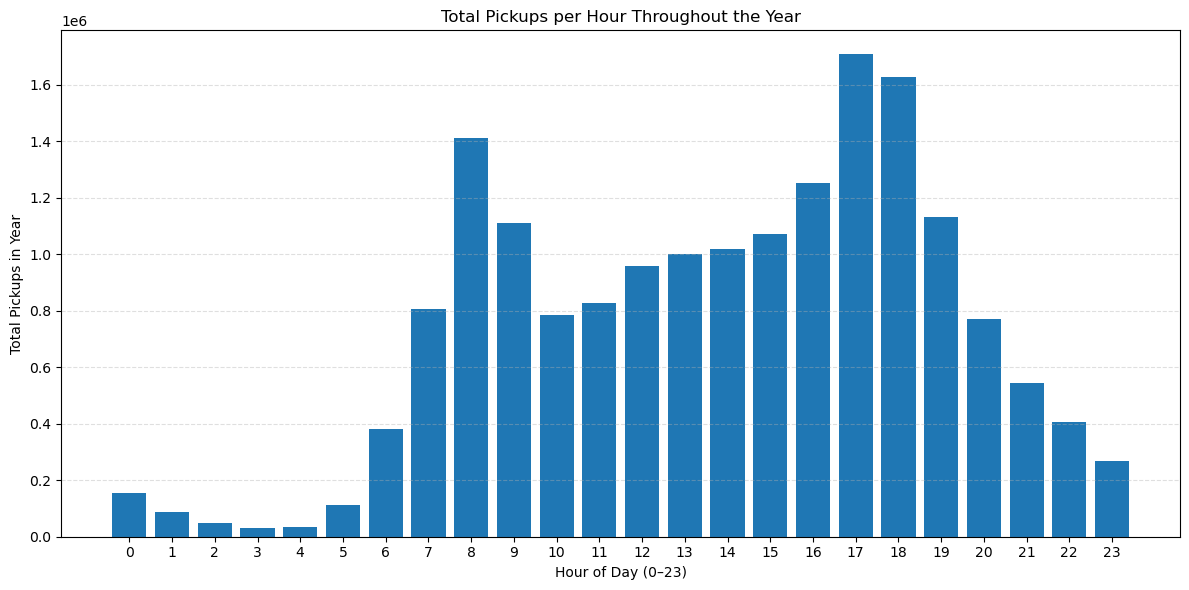

In [65]:
# Start by ploting the total pickup for each hour througout the year
# create an hour column
f['hour'] = f['starttime'].dt.hour

# --- Compute total pickups per hour ---
hourly_counts = f.groupby('hour').size()

# Ensure all 24 hours exist
hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Total Pickups in Year")
plt.title("Total Pickups per Hour Throughout the Year")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

1) Cluster the stations spatially (nearby departing stations should be grouped together)
in no less than 20 clusters. Tasks 2 and 3 will be based on this clustering, and they
should be completed for at least two clusters (more is preferable) so that you can
compare their respective results and discuss them

In [66]:
from sklearn.cluster import KMeans

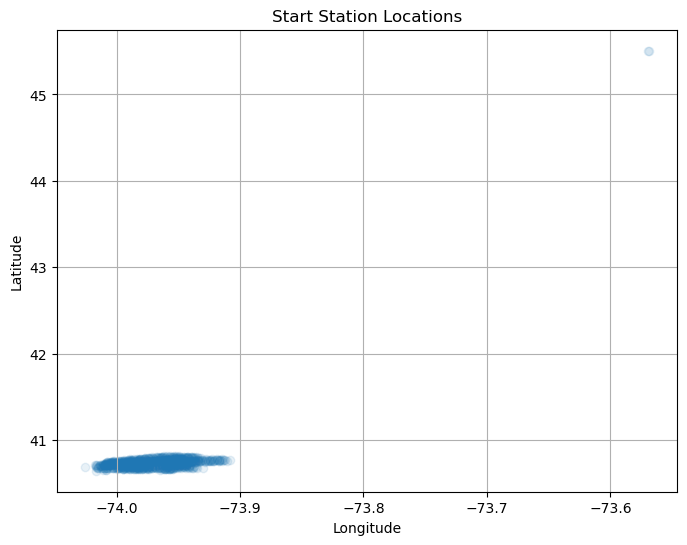

In [ ]:
# Create a new DataFrame with start station ID and coordinates, then plot the locations
f_cluster = f[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
f_cluster = f_cluster.drop_duplicates(subset='start_station_id')


plt.figure(figsize=(8, 6))
plt.scatter(f_cluster['start_station_longitude'], f_cluster['start_station_latitude'], alpha=0.1)

plt.title('Start Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [68]:
#There appears to be an outlier station far away from the other ones, let's find out which one it is and remove it
outlier_condition = (f_cluster['start_station_latitude'] > 41)
outlier_stations = f_cluster[outlier_condition]
print("Outlier stations:\n", outlier_stations)

Outlier stations:
        start_station_id  start_station_latitude  start_station_longitude
676612           3488.0               45.506364               -73.569463
714485           3650.0               45.506264               -73.568906


In [69]:
#Based on the latitude and longitude, stations 3488 and 3650 are located in Montreal, 
# so we will remove them from the clustering dataset and the original one
f_cluster = f_cluster[~outlier_condition]
f = f[f['start_station_latitude'] <= 41]


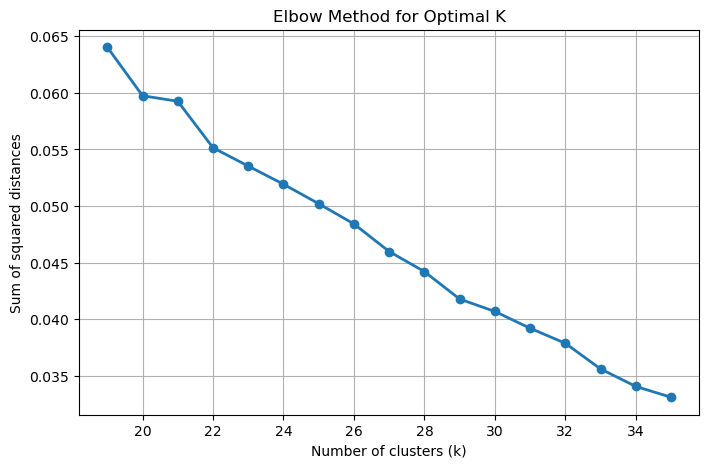

In [70]:
#Now, let's use the elbow method to determine the optimal number of clusters (k)
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

k_values = range(19, 36)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'o-', linewidth=2)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()


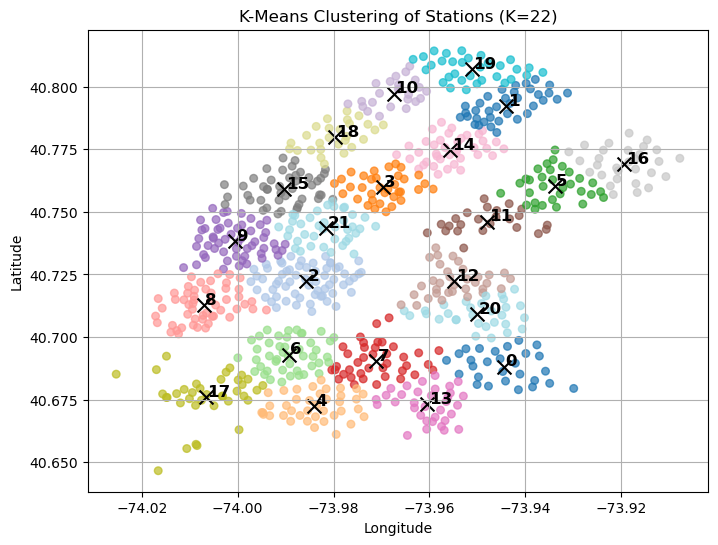

In [71]:
#We observe that k=22 should be a good choice for the number of clusters.

# Let's run the clustering and look at how the clusters look

# Extract coordinates
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

# Run K-Means with 22 clusters
kmeans = KMeans(n_clusters=22, random_state=42)
f_cluster['cluster'] = kmeans.fit_predict(coords)

# Get cluster centers
centers = kmeans.cluster_centers_

# Plot data points colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(
    f_cluster['start_station_longitude'],
    f_cluster['start_station_latitude'],
    c=f_cluster['cluster'], cmap='tab20', s=30, alpha=0.7
)

# Plot cluster centers
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='black', s=100, marker='x'
)

# Add numeric labels at each cluster center
for i, (lat, lon) in enumerate(centers):
    plt.text(
        lon + 0.0003, lat + 0.0003,   # small offset
        str(i), 
        fontsize=12, fontweight='bold', color='black'
    )

plt.title('K-Means Clustering of Stations (K=22)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [ ]:
# We want to only look at the clusters that make up the island of Manhattan
# We remove the other clusters from both f_cluster and f

clusters_to_remove = [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
clusters_to_keep = [2, 8, 9, 15, 21]

stations_to_remove = f_cluster.loc[
    f_cluster['cluster'].isin(clusters_to_remove),
    'start_station_id'
]

f_pickup= f[~f['start_station_id'].isin(stations_to_remove)]
f_dropoff= f[~f['end_station_id'].isin(stations_to_remove)]


f_pickup = f.merge(
    f_cluster[['start_station_id', 'cluster']],  
    on='start_station_id',
    how='left'  
)

# f_dropoff = f.merge(
#     f_cluster[['end_station_id', 'cluster']],  
#     on='start_station_id',
#     how='left'  
# )


KeyError: "['end_station_id'] not in index"

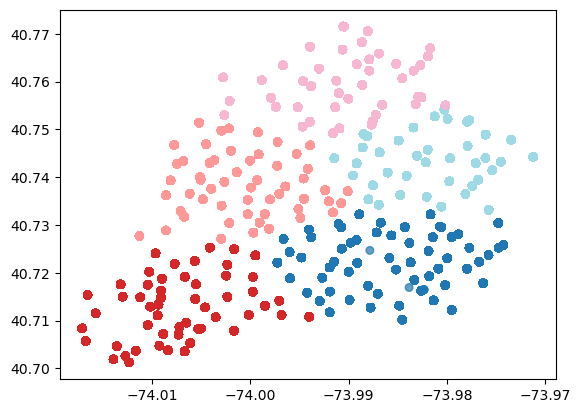

In [ ]:
# Test to see if the correct clusters were removed
# plt.scatter(f['start_station_longitude'], f['start_station_latitude'], c=f['cluster'], cmap='tab20', s=30, alpha=0.7)
# plt.show()


2) You are expected to build a prediction model that, at the end of a day, allows to
predict what the demand for a cluster of stations will be over the next 24 hours – i.e.
not the total demand for the next day, but how the time-series of the demand will look
like for the next day (e.g., given demand data until midnight of day 1, predict the
number of pickups for all 1h intervals (12-1am, 1-2am, 6-7am, 7-8am, …, 11-12pm)
in day 2). You should predict both the arrivals (i.e., bicycle dropoffs) and the
departures (pickups). You should use a time aggregation of one hour or less. You
can choose to use two different models or a single one to predict both. It is up to you
to determine the most effective way to formulate this problem as a machine learning
problem. You should not shuffle the data. You should instead use the data from
January to October (included) to train your model, and the data from November and
December as a test set. You can use any model you want

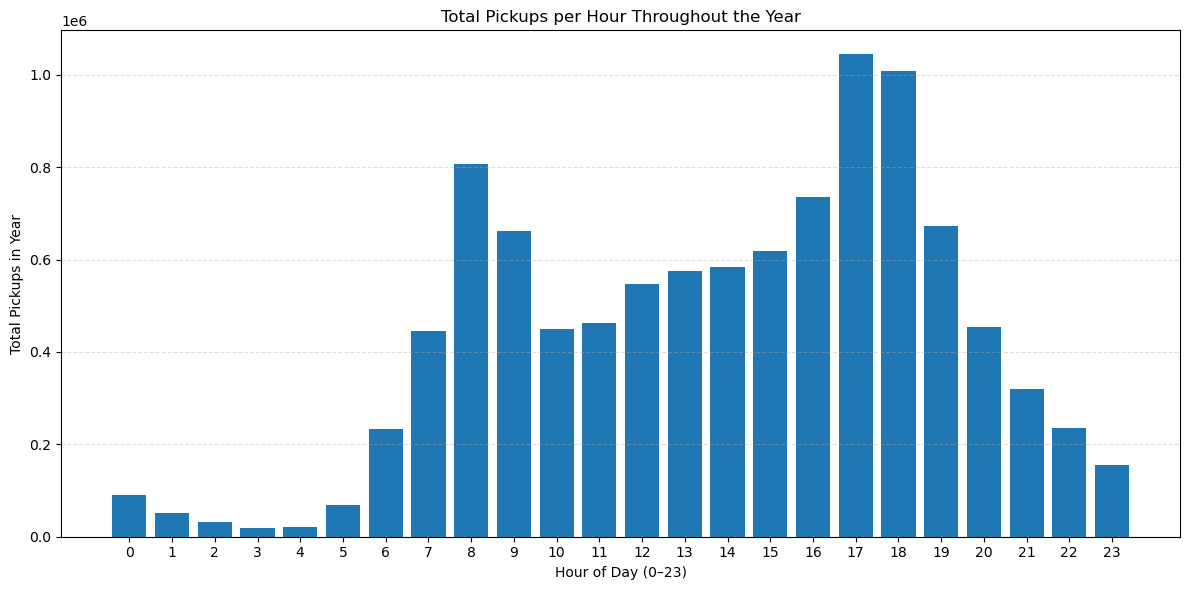

In [60]:
# Now let's plot the total pickup for each hour througout the year for the chosen clusters
# create an hour column
f['hour'] = f['starttime'].dt.hour

# --- Compute total pickups per hour ---
hourly_counts = f.groupby('hour').size()

# Ensure all 24 hours exist
hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Total Pickups in Year")
plt.title("Total Pickups per Hour Throughout the Year")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [61]:
# # --- Assumptions ---

# # Station id column:
# station_col = f['start_station_id']  # adjust if different

# # --- Build day & hour keys ---
# f['day']  = f['starttime'].dt.day    # midnight-normalized dates (YYYY-MM-DD as Timestamp)
# f['hour'] = f['starttime'].dt.hour            # 0..23

# # --- Group by cluster/day/hour and pivot to day x hour ---
# grp = f.groupby(['cluster', 'day', 'hour']).size()

# # Make sure all 24 hours exist in every pivot
# def pivot_cluster(g):
#     df = (g.unstack('hour', fill_value=0)
#             .reindex(columns=range(24), fill_value=0))
#     return df

# cluster_pivot = grp.groupby(level='cluster', group_keys=False).apply(pivot_cluster)

# # --- Ensure all days in your year appear, even if zeros (nice for modeling) ---
# date_min = f['day'].min()
# date_max = f['day'].max()
# all_days = pd.date_range(date_min, date_max, freq='D')

# def reindex_days(df):
#     return df.reindex(all_days, fill_value=0)

# #cluster_pivot = cluster_pivot.groupby(level='cluster', group_keys=True)\
# #                             .apply(reindex_days)

# # Now `cluster_pivot` has a MultiIndex row (cluster, day) and columns 0..23.
# # If you prefer separate tables per cluster:
# cluster_tables = {
#     c: cluster_pivot.xs(c, level='cluster').rename_axis('day')
#     for c in cluster_pivot.index.get_level_values('cluster').unique()
# }

# # change the number to see for each cluster
# cluster_tables[8]



In [ ]:
# Drop columns 
f.drop(columns=['bikeid', 'gender', 'birth_year', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'usertype'], axis=1, inplace=True)

# Add column to 'f' representing day of the week
f['day_of_week'] = f['starttime'].dt.dayofweek

In [ ]:
# Make new dataframe with bike counts per hour

f["starttime"] = pd.to_datetime(f["starttime"])

f["hour_start"] = f["starttime"].dt.floor("H")

hourly = (
    f.groupby("hour_start")
      .size()
      .reset_index(name="bike_count")
)

hourly["hour_of_day"] = hourly["hour_start"].dt.hour
hourly["weekday"] = hourly["hour_start"].dt.dayofweek

hourly

/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_4727/351790435.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f["hour_start"] = f["starttime"].dt.floor("H")


,hour_start,bike_count,hour_of_day,weekday
0,2018-01-01 00:00:00,71,0,0
1,2018-01-01 01:00:00,99,1,0
2,2018-01-01 02:00:00,51,2,0
3,2018-01-01 03:00:00,41,3,0
4,2018-01-01 04:00:00,18,4,0
...,...,...,...,...
8737,2018-12-31 19:00:00,91,19,0
8738,2018-12-31 20:00:00,115,20,0
8739,2018-12-31 21:00:00,48,21,0
8740,2018-12-31 22:00:00,54,22,0


In [23]:
# create weekday dummy variables
hourly_with_dummies = pd.get_dummies(
    hourly,
    columns=["weekday"],
    prefix="wd",
    dtype=int
)

In [24]:
hourly_with_dummies.head()

,hour_start,bike_count,hour_of_day,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6
0,2018-01-01 00:00:00,71,0,1,0,0,0,0,0,0
1,2018-01-01 01:00:00,99,1,1,0,0,0,0,0,0
2,2018-01-01 02:00:00,51,2,1,0,0,0,0,0,0
3,2018-01-01 03:00:00,41,3,1,0,0,0,0,0,0
4,2018-01-01 04:00:00,18,4,1,0,0,0,0,0,0


In [25]:
weekday_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

# build a rename dictionary for the dummy columns
rename_dict = {f"weekday_{k}": v for k, v in weekday_names.items()}

# apply renaming (works with your dummies, whatever their prefix)
hourly_with_dummies = hourly_with_dummies.rename(columns=rename_dict)

In [ ]:
# Change names of the dummy columns to actual weekday names 
weekday_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

rename_dict = {f"wd_{k}": v for k, v in weekday_names.items()}

hourly_with_dummies = hourly_with_dummies.rename(columns=rename_dict)

hourly_with_dummies.head()

,hour_start,bike_count,hour_of_day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2018-01-01 00:00:00,71,0,1,0,0,0,0,0,0
1,2018-01-01 01:00:00,99,1,1,0,0,0,0,0,0
2,2018-01-01 02:00:00,51,2,1,0,0,0,0,0,0
3,2018-01-01 03:00:00,41,3,1,0,0,0,0,0,0
4,2018-01-01 04:00:00,18,4,1,0,0,0,0,0,0


In [ ]:
# define cutoff
cutoff = pd.Timestamp("2018-11-01")

# train: start → end of October 2018
X_train = hourly_with_dummies[hourly_with_dummies["hour_start"] < cutoff]

# test: November 1st 2018 → end
X_test = hourly_with_dummies[hourly_with_dummies["hour_start"] >= cutoff]

In [29]:
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

In [43]:
def my_plot(regr, x, y, size=0.1):

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean absolute error    
    print("Mean Absolute error (MAE): %.2f"% np.mean(abs(regr.predict(x) - y)))
    # The mean squared error
    print("Root Mean squared error: %.2f"
          % np.sqrt(np.mean((regr.predict(x) - y) ** 2)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
          
    # Plot outputs
    plt.scatter(y, regr.predict(x), color='blue',linewidth=3)
    plt.plot([0, 5500], [0, 5500], color="red")
    plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
    plt.xlabel("observed")
    plt.ylabel("predicted")
    
    plt.show()

In [35]:
# Let's build lagged features for bike_count with a lag of 168 hours (1 week)
hourly_lagged = buildLaggedFeatures(hourly_with_dummies, columns=["bike_count"], lag=168, dropna=True)
hourly_lagged.head()

,hour_start,bike_count,hour_of_day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,...,bike_count_lag159,bike_count_lag160,bike_count_lag161,bike_count_lag162,bike_count_lag163,bike_count_lag164,bike_count_lag165,bike_count_lag166,bike_count_lag167,bike_count_lag168
168,2018-01-08 00:00:00,24,0,1,0,0,0,0,0,0,...,80.0,61.0,44.0,24.0,19.0,18.0,41.0,51.0,99.0,71.0
169,2018-01-08 01:00:00,16,1,1,0,0,0,0,0,0,...,122.0,80.0,61.0,44.0,24.0,19.0,18.0,41.0,51.0,99.0
170,2018-01-08 02:00:00,9,2,1,0,0,0,0,0,0,...,200.0,122.0,80.0,61.0,44.0,24.0,19.0,18.0,41.0,51.0
171,2018-01-08 03:00:00,8,3,1,0,0,0,0,0,0,...,209.0,200.0,122.0,80.0,61.0,44.0,24.0,19.0,18.0,41.0
172,2018-01-08 04:00:00,23,4,1,0,0,0,0,0,0,...,255.0,209.0,200.0,122.0,80.0,61.0,44.0,24.0,19.0,18.0


In [40]:
hourly_lagged.head()

,hour_start,bike_count,hour_of_day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,...,bike_count_lag159,bike_count_lag160,bike_count_lag161,bike_count_lag162,bike_count_lag163,bike_count_lag164,bike_count_lag165,bike_count_lag166,bike_count_lag167,bike_count_lag168
168,2018-01-08 00:00:00,24,0,1,0,0,0,0,0,0,...,80.0,61.0,44.0,24.0,19.0,18.0,41.0,51.0,99.0,71.0
169,2018-01-08 01:00:00,16,1,1,0,0,0,0,0,0,...,122.0,80.0,61.0,44.0,24.0,19.0,18.0,41.0,51.0,99.0
170,2018-01-08 02:00:00,9,2,1,0,0,0,0,0,0,...,200.0,122.0,80.0,61.0,44.0,24.0,19.0,18.0,41.0,51.0
171,2018-01-08 03:00:00,8,3,1,0,0,0,0,0,0,...,209.0,200.0,122.0,80.0,61.0,44.0,24.0,19.0,18.0,41.0
172,2018-01-08 04:00:00,23,4,1,0,0,0,0,0,0,...,255.0,209.0,200.0,122.0,80.0,61.0,44.0,24.0,19.0,18.0


In [41]:
# define cutoff
cutoff = pd.Timestamp("2018-11-01")

# train: start → end of October 2018
X_train = hourly_lagged[hourly_lagged["hour_start"] < cutoff]

# test: November 1st 2018 → end
X_test = hourly_lagged[hourly_lagged["hour_start"] >= cutoff]

Coefficients: 
 [-3.05295588e+00  1.56627396e+01  1.76054089e+01  2.55578374e+00
 -0.00000000e+00 -2.74222783e+00 -5.58127524e+01 -6.69907660e+01
  1.11551368e+00 -5.08644199e-01  1.85819153e-01 -5.48310014e-02
  3.80542438e-02 -2.29022946e-02 -2.11758114e-02 -4.00055301e-02
  2.43060667e-01 -1.29682503e-01 -3.04531625e-02  7.68819025e-02
 -1.21315149e-01  1.03090206e-01 -4.72396780e-02 -3.41062491e-03
  3.96504501e-02 -5.42733029e-02  8.77066422e-03  3.74892688e-02
 -5.87080812e-02  7.09829777e-02 -3.82895156e-02  3.75920478e-01
 -4.08305167e-01  1.12728556e-01  2.10436800e-03  1.47107240e-03
 -3.68274807e-02  4.25012216e-02  6.26460162e-03 -4.79074393e-02
 -2.17484830e-02  4.39498931e-04  3.17389448e-02 -2.83810354e-02
  2.81588595e-02 -1.22067981e-02 -3.15869538e-02  2.53258941e-02
  2.57404765e-02 -1.57732811e-02 -4.00075719e-05  7.76955347e-03
  9.56178523e-03 -1.13362793e-03 -3.71772965e-02  3.67550517e-02
 -3.71302450e-02  5.82660094e-02 -2.42852419e-02  1.49686248e-02
  1.44322

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.341e+08, tolerance: 9.216e+05
  model = cd_fast.enet_coordinate_descent(


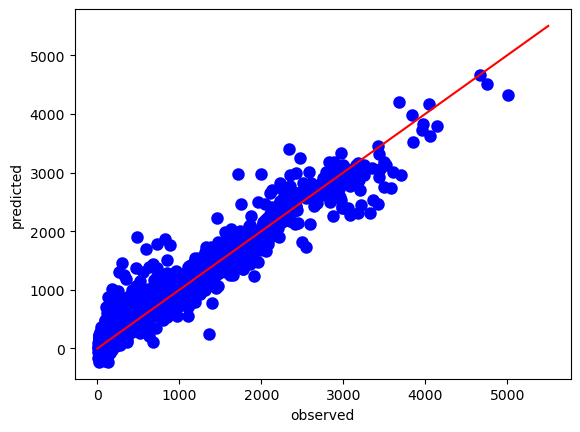

In [ ]:
# Let's fit a Lasso regression model on X_train to predict bike_count 
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(
    X_train.drop(columns=["hour_start", "bike_count"]),
    X_train["bike_count"]
)
# Now let's evaluate the model on the test set
my_plot(
    lasso,
    X_test.drop(columns=["hour_start", "bike_count"]),
    X_test["bike_count"]
)

In [ ]:
def plotprediction(series, pred_series, metrics, labels=["original", "predicted"], x_axis=None, plot_intervals=False, scale=1.96, plot_anomalies=False, title="prediction"):

    plt.figure(figsize=(15,5))
    plt.title(title)
    if x_axis is None:
        x_axis=series.index
    
    plt.plot(x_axis, pred_series, "g", label=labels[1])
    plt.plot(x_axis, series, label=labels[0])
    plt.legend(loc="upper right")
    plt.grid(True)
    
    ax = plt.gca()
    ax.text(0.01, 0.95, "\n".join(metrics),
            transform=ax.transAxes, ha="left", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.75))
    plt.tight_layout()
    # Plot confidence intervals for smoothed values
    plt.show()


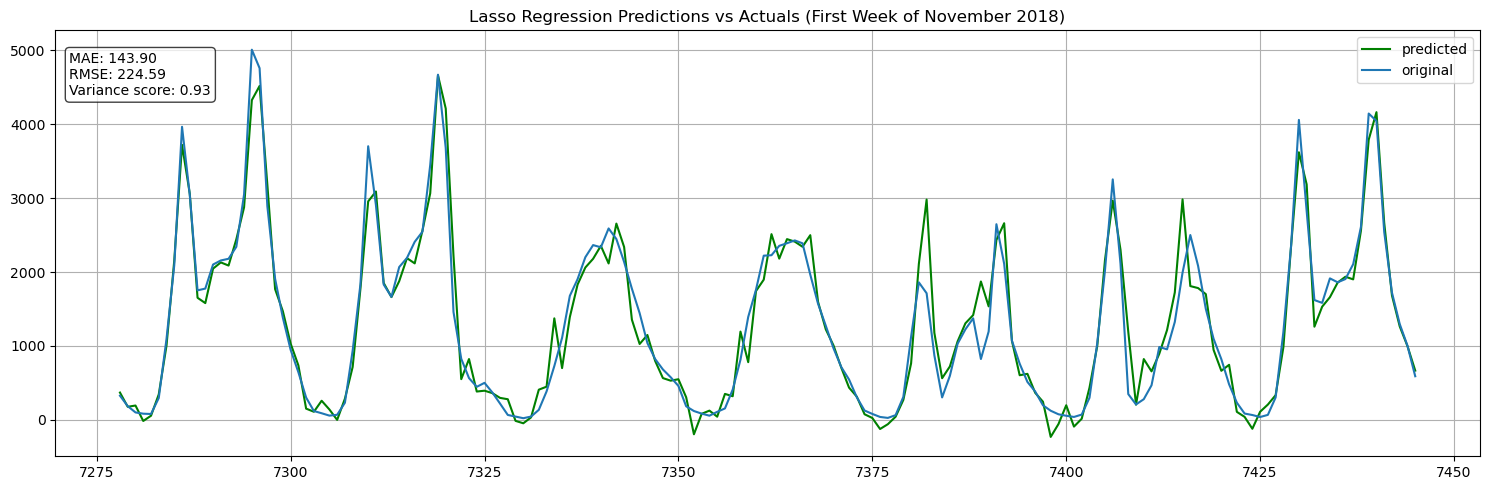

In [49]:
# Plot predictions vs actuals, but only for first week of November for clarity
plotprediction(
    series=X_test["bike_count"].iloc[:24*7],
    pred_series=pd.Series(
        lasso.predict(
            X_test.drop(columns=["hour_start", "bike_count"])
        ),
        index=X_test.index
    ).iloc[:24*7],
    metrics=[
        f"MAE: {np.mean(abs(lasso.predict(X_test.drop(columns=['hour_start', 'bike_count'])) - X_test['bike_count'])):.2f}",
        f"RMSE: {np.sqrt(np.mean((lasso.predict(X_test.drop(columns=['hour_start', 'bike_count'])) - X_test['bike_count']) ** 2)):.2f}",
        f"Variance score: {lasso.score(X_test.drop(columns=['hour_start', 'bike_count']), X_test['bike_count']):.2f}"
    ],
    title="Lasso Regression Predictions vs Actuals (First Week of November 2018)"
)


3) Overnight, the bike-sharing company manually repositions its bikes to ensure that
demand for the next day can be met. You are expected to use the outputs from the
prediction model above to compute the required number of bicycles to be placed in
each cluster of stations analyzed in Task 2 at the beginning of the next day. To
compute this number, you can use the cumulative of the arrivals and departures. The
goal is to ensure that, over the duration of the next day, there will never be a shortage
of bikes – or, if there is, the goal is to minimize the number of bikes in deficit. The
number of bicycles required can be estimated by extrapolating the maximum
difference between the number of departures and arrivals.